For effectively viewing this notebook, go here:

https://nbviewer.jupyter.org/github/skyimager/my-learning-notebooks/blob/master/paper-reviews/deep-learning/architectures/detection/retinanet/focal_loss_retinanet.ipynb

In this post, we review the paper **[Focal Loss for Dense Object Detection](./focal_loss.pdf)**, and focus on explaining **"focal loss"** to readers, as introduced in the [paper](./focal_loss.pdf).

<br>

<center><img src="./images/imbalance.jpeg" width="300"/></center>

## General introduction to Object detection:

As of the currect state, Object detection algorithms can be divided into two categories: 
 - one-state detectors and 
 - two-stage detectors. 

Let us understand the two algorithms in brief: 

### Two-stage detectors (like R-CNN, Faster R-CNN, FPN, Mask R-CNN):

- They are applied to a sparse set of candidate object locations. 
- the two stages are:

    - **The Proposal Stage (Stage 1):**  generate candidate object locations for detection by select search or regional proposal network. In this stage, most of the background samples are filtered out, generating a small number of candidate object locations (e.g., 1-2k). As a result we get a sparse set of candidate locations as the ouput from this stage.
    
    - **The Classification Stage (Stage 2):** classify only the candidate locations as one of the foreground classes or as background using a convolutional neural network.

The diagram below shows the 2-stage detection process:
<center><img src="./images/two_stage.jpeg" width="600"/></center>

- Owing to the spare set of candidates, the accuracy is high but speed is low due to the two-stage operation.
 

### One-stage detectors (like SSD, YOLO):

- They skip regional proposal and classification is directly applied over a dense sampling of possible object locations. This one stage proces makes them simpler and faster.

The diagram below shows the 1-stage detection process:
<center><img src="./images/one_stage.jpeg" width="500"/></center>

- **Extreme class imbalance:**: Such detectors, often end up with large number of bounding boxes in which no objects are present. This gives rise to an extreme imbalance between the foreground and the background class. For example in YOLO there may be several targets on each image. But the output of the last layer of YOLO V2 is $13 \times 13 \times 5$, which is $845$ candidate! A large number of (simple and easy to distinguish) negative samples occupy a large proportion in the loss, so that useful loss can not be returned.

<center><img src="./images/one_stage_imb.png" width="500"/></center>

- **How does class imbalance effect training?:** This class imbalance causes loss in accuracy. 
    - Consider a usual case in one-stage detectors, where we have 100 bounding boxes, among which 96 of them are negative samples, and 4 of them are positive samples. 
    - If the network predicts all samples as negative samples, the loss of the negative sample will be 0, the loss of the positive sample will be 1 and there are four positive samples,so, the loss value will be 4.
    - After receiving the loss value, the network starts to adjust the parameters. After several rounds of training, the model now tags 98 samples as negative. Now 2 negative samples will have a loss value more than zero. This 2% gap is also the loss of the negative sample, assuming that 96 negative samples are lost by 2%, and the negative loss provided by the negative sample is 1.92. At this point, the positive sample has already done a good job, and the loss of the positive sample alone has dropped to 2.
    - At this time, we found that the total loss we will return is 3.92. As the iterations continue, we see that the loss calculation is largely driven by the negative samples. As gradient descent would move in the direction of the larger loss value, the network would update unsatisfactorily.

#### The authors of the present paper, try to address this class imbalance problem of one-stage object detectors and propose a solution for the same.

### A brief summary of the paper: 

**Problem:**
 - **one stage detectors** for object detection have been faster but **lower in accuracy** than two stage detectors. 

**Root cause:**
 - extreme foreground-background **class imbalance** encountered during training of one-stage detectors causes the low accuracy.

**Solution:**
 - Introducing **Focal loss**, a dynamically scaled cross entropy loss, where the scaling factor decays to zero as confidence in the correct class increases. The new loss function down-weights the loss assigned to well-classified examples and _focuses_ training on a sparse set of hard examples, thereby preventing the vast number of easy negatives from overwhelming the detector during training.

## Characteristics of Focal loss:

- Focal loss is mainly implemented to solve the imbalance of positive and negative samples in one-stage target detection. 
- down-weight easy examples .
- focus training on hard negatives.
- prevent large number of easy negatives from overwhelming the detector during training. 
- It can also be understood as an improved hard example mining for one-stage detectors.

## Explaining Focal loss and its importance

Focal loss is invented as a replacement for Cross Entropy loss when training with highly imabalanced classes. First let us see the Cross Entropy loss function and understand the problem with it. Here, for simplicity we are considering only binary classification, however, even for multi-class cases the same logic will hold. 

The Cross Entropy (CE) loss function for binary classification is given as: 

$$
\large \mathrm{CE(p,y)}=-\mathrm{ylog(p)}-(1-y)\log\left(1-p\right)=\left\{\begin{array}{ll}{-\log p} & {y=1} \\ {-\log \left(1-p\right),} & {otherwise}\end{array}\right.
$$

Here $p$ gives the predicted probability for class 1, between 0-1. 

Now, to simplify the representation and keep the notation same as the original paper, let us define $p_t$ as:

$$
\mathrm{p_t}=\left\{\begin{array}{ll}{p} & {y=1} \\ {1-p,} & {otherwise}\end{array}\right.
$$

and so CE loss can be represented as:

$$
\mathrm{CE(p,y)}=\mathrm{CE(p_t)}=-\mathrm{log(p_t)}
$$

Let us now explore the signature of CE loss to understand the problem that lies within:

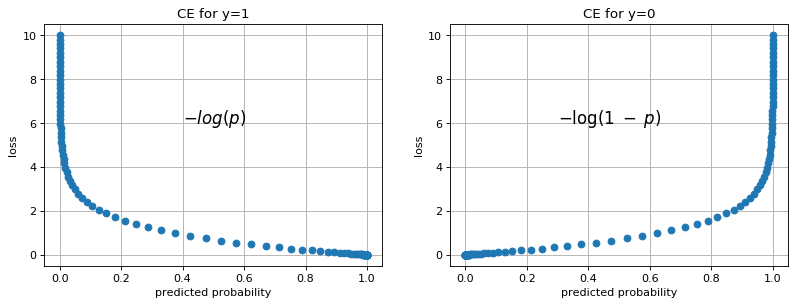

In [37]:
'''Explore the signature of CE loss function'''
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

sigmoid = lambda x: 1/(1 + np.exp(-x))
x = np.linspace(-10,10,100)

f = plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
f.add_subplot(1,2, 1)
plt.title('CE for y=1')
plt.plot(sigmoid(x), [-math.log(x) for x in sigmoid(x)], 'o')
plt.grid()
plt.xlabel("predicted probability")
plt.ylabel("loss")
plt.text(0.4, 6, r'$ -log(p)$', fontsize=15)

f.add_subplot(1,2, 2)
plt.title('CE for y=0')
plt.plot(sigmoid(x), [-math.log(1-x) for x in sigmoid(x)], 'o')
plt.grid()
plt.xlabel("predicted probability")
plt.ylabel("loss")
plt.text(0.3, 6, r'$ -\log(1\; -\; p)$', fontsize=15);

Two important things to note from the above figure are:

- **Observation 1:** In case of positive samples (left figure), it can be seen that even for **easily classified positives** where $p >  0.5$, CE loss incurs a value even though low. The authors claim that _**"when summed over a large number of easy examples, these small loss values can overwhelm the rare class."**_

- **Observation 2:** In the case of a negative samples, for **easily classified negatives** where $p <  0.5$, CE loss incurs a value. The authors claim that _**"these easily classified negatives comprise the majority of the loss and dominate the gradient"**_

### As a measure to overcome the probelms noticed in observation 1 and observation 2, authors have introduced **Focal Loss (FL).**

Intuitively, Focal loss can be defined as:

$$
\large \mathrm{FL} =\mathrm{CE} * \text{modulating_factor}
$$

where: <br>
1. **modulating factor, M** = $(1-p_t)^{\gamma}$ and <br>
2. **focusing parameter** = $\gamma$. <br>

Here  $\gamma > 0$ and is a tunable. <br>

The modulating factor can be represented as:

$$
\mathrm{M}=\left\{\begin{array}{ll}{(1-p)^{\gamma}} & {y=1} \\ {p^{\gamma}} & {otherwise}\end{array}\right.
$$

In compressed notation, FL can be written as:

$$
\large \mathrm{FL} =-\log p_t * \left(1-p_t\right)^{\gamma} 
$$

The complete formula for FL is given as:

$$
\mathrm{FL}= -y(1-p)^{\gamma}log p - (1-y)p^{\gamma}log(1-p)
$$

**However, it is to be noted that this precise form of focal loss is not cruical, but its only the property by which it down-weights easy examples.** Authors have shown that focal loss in other forms having the same property, will yield similar results. 

### Understanding the Focal loss equation:

To understand FL, let us understand modulating factor a little more, and see how it is affecting FL:

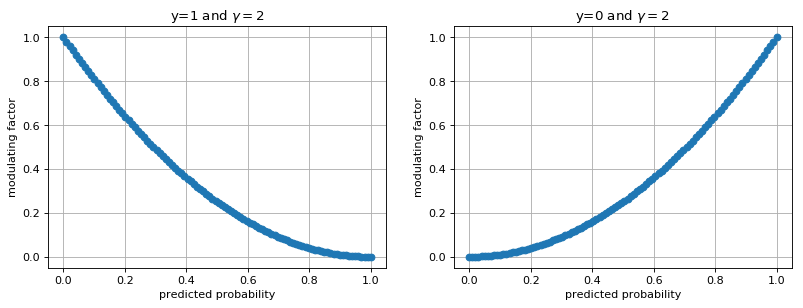

In [45]:
'''Explore the signature of Modulating factor M'''
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

mf_1 = lambda p: (1 - p)**2
mf_0 = lambda p: (p)**2
p = np.linspace(0,1,100)

f = plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
f.add_subplot(1,2, 1)
plt.title('y=1 and $\gamma = 2$')
plt.plot(p, mf_1(p), 'o')
plt.grid()
plt.xlabel("predicted probability")
plt.ylabel("modulating factor")

f.add_subplot(1,2, 2)
plt.title('y=0 and $\gamma = 2$')
plt.plot(p, mf_0(p), 'o')
plt.grid()
plt.xlabel("predicted probability")
plt.ylabel("modulating factor");

- Since $p_t$ has a range of $[0,1]$, M has a range of $[0,1)$. As such always **M < 1**, ans so FL is always less than CE loss.

From the graphs above we can see that:
 - When an example is misclassified and $p_t$ is small, the modulating factor is near 1 and the loss is unaffected.
 - For **easy classified examples** as $p_t→1$, the modulating factor goes to 0 and the loss for well-classified examples is down-weighted. 

The focusing parameter $\gamma$ smoothly adjusts the rate at which easy examples are down-weighted. When $\gamma = 0$, FL is equivalent to CE, and as $\gamma$ is increased the effect of the modulating factor is likewise increased.

<center><img src="images/pogtc.png" width="600"/></center>


Intuitively, the modulating factor reduces the loss contribution from easy examples and extends the range in which an example receives low loss. Let us look at some examples with $\gamma = 2$. 

 - Case 1: An **easy classified positive** with $y=1$ and $p_t=0.9$. Here: <br>
     - CE = -log(0.9) = 0.105 <br>
     - M =  $(1-0.90)^2$ = 0.01 <br>
     - FL = CE*M = 0.001 <br>
   We see FL = 105% lower than CE loss 


 - Case 2: An **easy classified positive** with $y=1$ and $p_t=0.98$. Here: <br>
     - CE = -log(0.98) = 0.020 <br>
     - M =  $(1-0.98)^2$ = 0.0004 <br>
     - FL = CE*M = 0.000008 <br>
   We see FL = 2500% lower than CE loss 


 - Case 3: An **easy classified negative** with $y=0$ and $p_t=0.2$. Here: <br>
     - CE = -log(1-0.2) = 0.223 <br>
     - M =  $(0.2)^2$ = 0.04 <br>
     - FL = CE*M = 0.00892 <br>
   We see FL = 96% lower than CE loss 
 
 
 - Case 4: A **hard negative** with $y=0$ and $p_t=0.8$. Here: <br>
     - CE = -log(1-0.8) = 1.609  <br>
     - M =  $(0.8)^2$ = 0.64 <br>
     - FL = CE*M = 1.029 <br>
   We see FL = 2.5% lower than CE loss
   
#### We see that for hard negatives the decrease in FL is very low as compared to CE. This in turn increases the importance of correcting misclassified examples (whose loss is scaled down by at most $4x$ for $p_t <= .5$ and $\gamma =2$).

The lambda adjusts the rate at which the weight of the simple sample decreases. When the lambda is 0, it is the cross entropy loss function. When the lambda increases, the influence of the adjustment factor increases. The experiment found that lambda is 2 is optimal.

### Balanced Focal Loss

In addition, authors have also introduced an $\alpha$ balanced variant of FL (lets call it $\alpha-\text{Focal loss}$). The balance factor is added to balance the uneven ratio of the positive and negative samples themselves:

$$
\mathrm{FL}= -\alpha_t \left(1-p_t\right)^{\gamma} \log p_t
$$

Here $\alpha_t$ is defined analogously to $p_t$.

It should be noted that adding alpha only balances the importance of positive and negative samples, and does not solve the problem of easy and hard samples.

## Focal loss used in Retinanet Training:

The authors have used FL to train a new object detection architecture called **Retinanet.** It forms a single FCN comprised of a ResNet-FPN backbone, a classification subnet, and a box regression subnet.

<center><img src="images/retinanet.png" width="800"/></center>

Important points to note in Retinanet training are:

- FL is used as the loss on the output of the classification subnet.

- During training, the focal loss is applied to all ∼100k anchors in each sampled image. This stands in contrast to common practice of using heuristic sampling (RPN) or hard example mining (OHEM, SSD) to select a small set of anchors (e.g., 256) for each minibatch. 

- The total focal loss of an image is computed as the sum of the focal loss over all ∼100k anchors, normalized by the number of anchors assigned to a ground-truth box. The normalization is performed by the number of assigned anchors and not total anchors, since the vast majority of anchors are easy negatives and receive negligible loss values under the focal loss. 

- $\alpha$ the weight assigned to the rare class, also has a stable range, but it interacts with $\gamma$ making it necessary to select the two together. The range for $\alpha$ is [0.25,0.75] and the range for $\gamma$ is [0,5]

- The authors got best results with $\gamma=2$ and $\alpha = 0.25$.